# Acme Gourmet Meals: Sales Analytics Case Study

**SQL (PostgreSQL)**: Aggregations, joins, subqueries/CTEs, date-time analysis, window functions.

**Python**: `pandas` for analysis tables and `matplotlib`/`seaborn` for visualization.

In this case study I analyze Acme Gourmet Meals (AGM) sales data to answer questions a data scientist might typically encounter: Where does revenue come from? When does demand spike? Which products and customer segments matter most? The analysis reveals several interesting patterns in the data. 

- Revenue varies significantly by location, with Berkeley generating $25.0M (25.4% of total revenue) compared to Nashville's $14.6M (14.8%). However, average transaction size remains remarkably consistent at around $64 across all five stores, indicating that volume differences rather than pricing drive the revenue gap. 
- Weekend demand is substantial, with Saturday and Sunday accounting for roughly 38.5% of weekly revenue, while Tuesday consistently represents the low point at about 36% of Saturday's volume. Seasonality appears moderate, with monthly revenue ranging from $7.6M to $9.0M and peaks occurring in August and October.
- Product concentration is notable throughout the dataset. Pistachio Salmon emerges as the top-selling meal across every store location and every month, representing 22.23% of total units sold and signaling a clear hero product. The customer acquisition funnel also reveals an opportunity, with 35 customers who signed up but never completed a purchase.

**Note:** This analysis was completed against a PostgreSQL database hosted in a UC Berkeley MIDS AWS environment. The underlying database is not publicly accessible, but the SQL and analytical approach are included to make the work reviewable.

### Supporting Code

In [3]:
import math
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Database connection to UC Berkeley AWS PostgreSQL instance
connection = psycopg2.connect(
    user = "postgres",
    password = "****", # hidden
    host = "postgres",
    port = "5432",
    database = "postgres"
)

Below I define a small helper to run a SQL `SELECT` and return the results as a `pandas` DataFrame. I also normalize numeric dtypes so counts don’t show up as floats.

In [5]:
def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "Run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # Modify float columns that really should be integers
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [6]:
rollback_before_flag = True
rollback_after_flag = True

## **1. Sales Queries**

In this section I focus on three metrics that explain why sales differ across stores and time: revenue, transaction count, and average revenue per transaction. 

### **1.1 Sales by Store Location**

How does much is revenue distributed by market, and is performance explained by customer volume or by average order size (AOV)? This query aggregates revenue and transactions by city and computes AOV to separate those drivers.

In [7]:
query = """

select  st.city as store_location,
        sum(total_amount) as total_sales_dollars,
        sum(total_amount)/1000000 as total_sales_million_dollars,
        count(*) as total_number_of_sales,
        round(sum(total_amount)/count(*),2) as average_dollar_amount_per_sale
        
from sales as sa
    join stores as st
        on sa.store_id = st.store_id
group by st.city
order by st.city

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,store_location,total_sales_dollars,total_sales_million_dollars,total_number_of_sales,average_dollar_amount_per_sale
0,Berkeley,25041060,25.041060,390375,64.15
1,Dallas,19408260,19.408260,302120,64.24
2,Miami,17692404,17.692404,275074,64.32
3,Nashville,14573172,14.573172,227721,64.00
4,Seattle,22024512,22.024512,342327,64.34


These bar chart compare the market sizes:

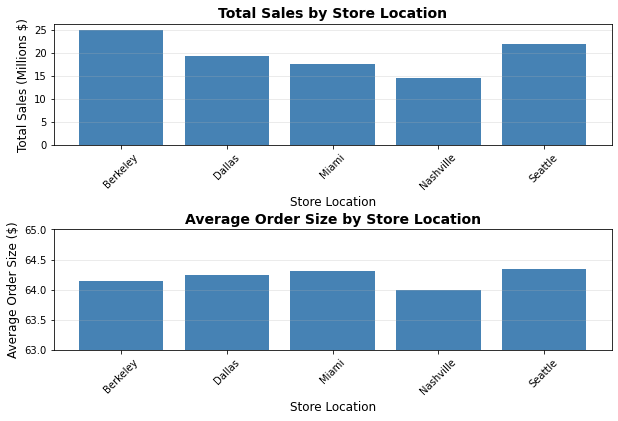

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ax1,ax2 = axes

# Total sales by store location
ax1.bar(df['store_location'], df['total_sales_million_dollars'], color='steelblue')
ax1.set_xlabel('Store Location', fontsize=12)
ax1.set_ylabel('Total Sales (Millions $)', fontsize=12)
ax1.set_title('Total Sales by Store Location', fontsize=14, fontweight='bold')

# Average order size by store location
ax2.bar(df['store_location'], df['average_dollar_amount_per_sale'], color='steelblue')
ax2.set_xlabel('Store Location', fontsize=12)
ax2.set_ylabel('Average Order Size ($)', fontsize=12)
ax2.set_title('Average Order Size by Store Location', fontsize=14, fontweight='bold')
ax2.set_ylim(bottom=63, top=65)

for ax in axes:
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.7)
plt.show()

Total revenue across all stores is ~$98.7M.
Berkeley leads with $25.0M (25.4%), followed by Seattle at $22.0M (22.3%); Nashville is lowest at $14.6M (14.8%). Average ticket is relatively consistent ($64.00–$64.34), so the revenue gap is primarily explained by transaction volume (e.g., Berkeley ~390k transactions vs Nashville ~228k). Following, opportunities for growth should be focused on traffic and conversion/retention as opposed to increased pricing.

### **1.2 Sales by Month**

How seasonal is demand, and which months should drive staffing and inventory planning? I summarize monthly revenue, transaction count, and average order volume to see whether seasonality is driven by traffic or changes in spend-per-visit.

In [9]:
query = """

select  extract(month from sale_date) as month_number,
        to_char(sale_date, 'Mon') as month_abbr,
        to_char(sale_date, 'Month') as month,
        sum(total_amount) as total_sales_dollars,
        round(sum(total_amount)/1000000,1) as total_sales_million_dollars,
        count(*) as total_number_of_sales,
        round(sum(total_amount)/count(*),2) as average_dollar_amount_per_sale
        
from sales
group by extract(month from sale_date),
         to_char(sale_date, 'Month'),
         to_char(sale_date, 'Mon')
order by month_number

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,month_number,month_abbr,month,total_sales_dollars,total_sales_million_dollars,total_number_of_sales,average_dollar_amount_per_sale
0,1,Jan,January,7803828,7.8,121955,63.99
1,2,Feb,February,7574280,7.6,117984,64.20
2,3,Mar,March,8779620,8.8,136653,64.25
3,4,Apr,April,8251284,8.3,128155,64.39
4,5,May,May,7977840,8.0,124380,64.14
5,6,Jun,June,8124108,8.1,126248,64.35
6,7,Jul,July,7993044,8.0,124290,64.31
7,8,Aug,August,9029808,9.0,140467,64.28
8,9,Sep,September,7578960,7.6,117974,64.24
9,10,Oct,October,8895108,8.9,138731,64.12


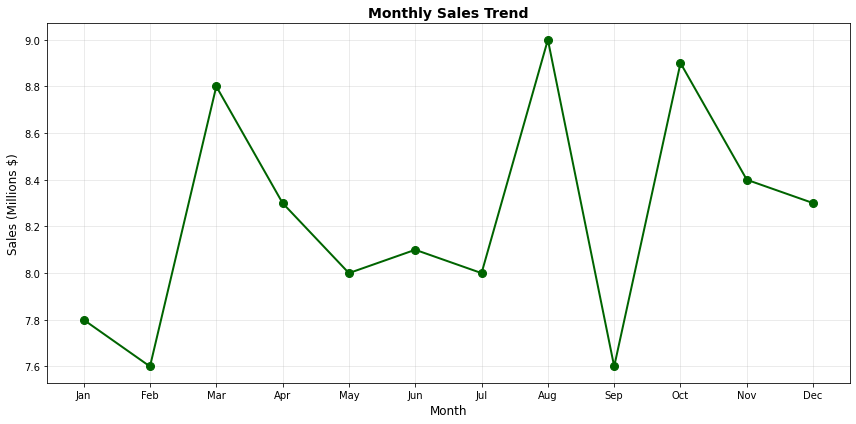

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df['month_abbr'], df['total_sales_million_dollars'], marker='o', linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales (Millions $)', fontsize=12)
plt.title('Monthly Sales Trend', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Monthly revenue has significant seasonality, ranging from ~$7.6M to ~$9.0M (about an 18% difference). Peaks occur in August ($9.0M) and October ($8.9M), while February and September are the softest months at roughly $7.6M. Staff planning and inventory should be prioritized around late-summer and early-fall. If the goal is smoothing revenue, advertisements could be targeted for the early-summer months.  

### **1.3 Sales by Day of Week**

What does the weekly demand curve look like, and where are the natural “slow days” vs “peak days”?

In [11]:
query = """

select  extract(dow from sale_date) as dow,
        to_char(sale_date, 'Day') as day_of_week,
        sum(total_amount) as total_sales_dollars,
        round(sum(total_amount)/1000000,1) as total_sales_million_dollars,
        count(*) as total_number_of_sales,
        round(sum(total_amount)/count(*),2) as average_dollar_amount_per_sale
        
from sales
group by extract(dow from sale_date),
         to_char(sale_date, 'Day')
order by dow

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,dow,day_of_week,total_sales_dollars,total_sales_million_dollars,total_number_of_sales,average_dollar_amount_per_sale
0,0,Sunday,18589068,18.6,289869,64.13
1,1,Monday,13167720,13.2,204909,64.26
2,2,Tuesday,6895332,6.9,107488,64.15
3,3,Wednesday,13952556,14.0,217288,64.21
4,4,Thursday,13834644,13.8,214969,64.36
5,5,Friday,12878628,12.9,201039,64.06
6,6,Saturday,19421460,19.4,302055,64.30


Weekends dominate, Saturday ($19.4M) and Sunday ($18.6M) together account for ~38.5% of weekly revenue. Tuesday is the clear trough ($6.9M). Average ticket stays very stable (~\($64\)), so the day-of-week curve is primarily volume/traffic driven. This pattern is actionable, AGM can predict weekend service levels and host Tuesday-exclusive offers to increase demand. 

### **1.4 Month-over-Month Growth**

How fast is the business growing (or shrinking) month to month, and is the change driven by transactions or AOV? This query uses `LAG()` to compute month-over-month percent changes in revenue and transactions.


In [12]:
query = """

with monthly as (
    select  date_trunc('month', sale_date)::date as month,
            sum(total_amount) as revenue,
            count(*) as transactions,
            round(sum(total_amount) / count(*), 2) as avg_ticket
    from sales
    group by 1
),
with_lag as (
    select  month,
            revenue,
            transactions,
            avg_ticket,
            lag(revenue) over (order by month) as prev_revenue,
            lag(transactions) over (order by month) as prev_transactions
    from monthly
)
select  month,
        revenue,
        transactions,
        avg_ticket,
        round(100.0 * (revenue - prev_revenue) / nullif(prev_revenue, 0), 2) as revenue_mom_pct,
        round(100.0 * (transactions - prev_transactions) / nullif(prev_transactions, 0), 2) as transactions_mom_pct
from with_lag
order by month

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,month,revenue,transactions,avg_ticket,revenue_mom_pct,transactions_mom_pct
0,2020-01-01,7803828,121955,63.99,NaN,NaN
1,2020-02-01,7574280,117984,64.20,-2.94,-3.26
2,2020-03-01,8779620,136653,64.25,15.91,15.82
3,2020-04-01,8251284,128155,64.39,-6.02,-6.22
4,2020-05-01,7977840,124380,64.14,-3.31,-2.95
5,2020-06-01,8124108,126248,64.35,1.83,1.50
6,2020-07-01,7993044,124290,64.31,-1.61,-1.55
7,2020-08-01,9029808,140467,64.28,12.97,13.02
8,2020-09-01,7578960,117974,64.24,-16.07,-16.01
9,2020-10-01,8895108,138731,64.12,17.37,17.59


## **2. Customer Analysis**

Revenue patterns are ultimately driven by customer behavior. Here I look at two practical angles, activation and geography. Some customers have not yet been motivated to make their first purchase. Largely, customers are concentrated in different locations, knowledge of which is crucial for delivery coverage, local marketing, and store-level planning.

### **2.1 Customers Who Signed Up But Never Made a Purchase**

How much demand is “stuck” between signup and first purchase? This query counts customers with zero purchases. Improving first-purchase conversion can cause fast growth because acquisition costs are already “spent” at signup.

In [13]:
query = """

select  count(*) as customers_with_no_purchases
from customers as c
where not exists (
    select 1
    from sales as s
    where s.customer_id = c.customer_id
)

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customers_with_no_purchases
0,35


There are 35 customers who signed up but never made a purchase. This is a measurable segment for activation experiments (e.g., onboarding emails, first-order incentives, reminders).

### **2.2 Customer Distribution by Zip Code**

Where are customers concentrated geographically, and how “local” is demand? This query shows customer counts and shares by ZIP code. 

In [14]:
query = """

select  zip,
        count(*) as customer_count,
        round(100.0 * count(*) / sum(count(*)) over(), 2) as percentage_of_customers
from customers
group by zip
order by customer_count desc

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,zip,customer_count,percentage_of_customers
0,33134,419,1.35
1,98117,315,1.01
2,98125,296,0.95
3,94602,260,0.84
4,94530,258,0.83
...,...,...,...
545,76182,1,0.00
546,37048,1,0.00
547,75025,1,0.00
548,76012,1,0.00


The customer base is spread across a long tail of ZIP codes (550 ZIPs in this output). The top ZIP (33134 in Coral Gables, Florida) contains only ~1.35% of customers, and the next two top ZIPs are near ~1%. This indicates that demand is not dominated by a single neighborhood. High dispersion can be good but it also means localized campaigns may need to be carefully targeted and measured.

### **2.3 Customer Value Segmentation**

Which customers are most valuable, and how can we segment them using only transactional history? This query computes a RFM view:
- **Recency**: days since last order
- **Frequency**: number of orders
- **Monetary**: total spend
It then assigns quintile scores using `NTILE(5)`.

In [15]:
query = """

with ref as (
    select max(sale_date)::date as asof_date
    from sales
),
customer_sales as (
    select  customer_id,
            max(sale_date)::date as last_purchase_date,
            count(*) as orders,
            sum(total_amount) as revenue
    from sales
    group by customer_id
),
rfm_raw as (
    select  cs.customer_id,
            (ref.asof_date - cs.last_purchase_date) as recency_days,
            cs.orders,
            cs.revenue,
            ntile(5) over (
                order by (ref.asof_date - cs.last_purchase_date) asc
            ) as recency_quintile,
            ntile(5) over (order by cs.orders desc) as frequency_score,
            ntile(5) over (order by cs.revenue desc) as monetary_score
    from customer_sales as cs
        cross join ref
),
rfm as (
    select  customer_id,
            recency_days,
            orders,
            revenue,
            (6 - recency_quintile) as recency_score,
            frequency_score,
            monetary_score,
            (6 - recency_quintile) + frequency_score + monetary_score as rfm_total
    from rfm_raw
)
select  customer_id,
        recency_days,
        orders,
        revenue,
        recency_score,
        frequency_score,
        monetary_score,
        rfm_total
from rfm
order by rfm_total desc, revenue desc

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df.head(20)

,customer_id,recency_days,orders,revenue,recency_score,frequency_score,monetary_score,rfm_total
0,20206,0,29,1956,5,5,5,15
1,20789,1,28,1956,5,5,5,15
2,13621,1,27,1956,5,5,5,15
3,20440,1,25,1956,5,5,5,15
4,12607,1,28,1956,5,5,5,15
5,7457,0,25,1956,5,5,5,15
6,7968,1,28,1956,5,5,5,15
7,15091,1,27,1956,5,5,5,15
8,26194,0,25,1956,5,5,5,15
9,20938,0,28,1956,5,5,5,15


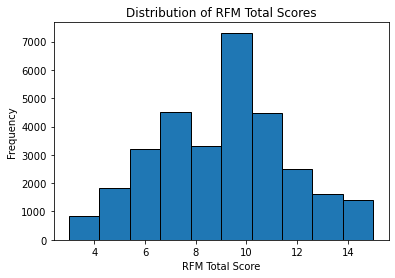

In [16]:
plt.hist(df['rfm_total'], bins=10, edgecolor='black')
plt.xlabel('RFM Total Score')
plt.ylabel('Frequency')
plt.title('Distribution of RFM Total Scores')
plt.show()


High RFM customers are candidates for retention perks and “VIP” treatment, where low RFM customers can be targeted with win-back campaigns. The RFM score distribution appears normal centered at around 9, with approximately 7,000 customers at the peak, indicating most customers fall into the moderate engagement category. The distribution tapers off at both extremes. 

## **3. Product Analysis**

In this section I look for overall demand scale, “hero” products dominating the mix, seasonality, and cross-dimension patterns (day-of-week × month) to inform staffing and menu strategy.

### **3.1 Top 10 Meals**

An overview of the top 10 meals by quantity sold.

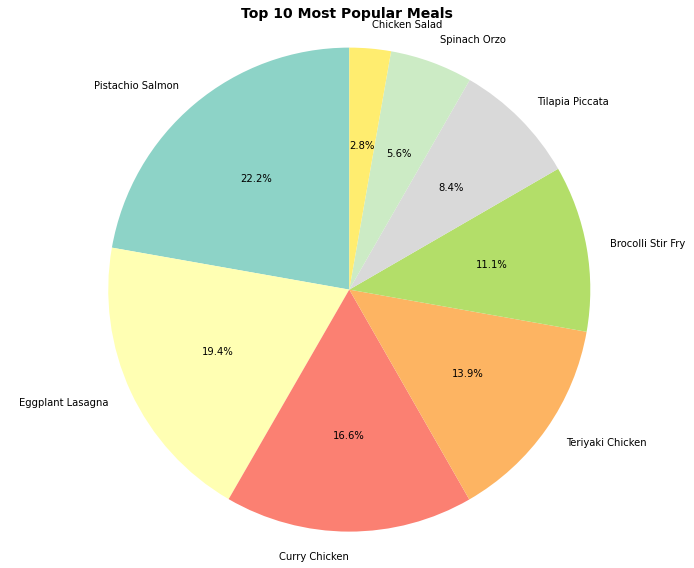

In [17]:
query = """
select  pr.description as meal_name,
        sum(li.quantity) as total_quantity
from line_items as li
    join products as pr on li.product_id = pr.product_id
group by pr.description
order by total_quantity desc
limit 10
"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(df)))
plt.pie(df['total_quantity'], labels=df['meal_name'], autopct='%1.1f%%', 
        startangle=90, colors=colors)
plt.title('Top 10 Most Popular Meals', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

### **3.2 Most Popular Meal by Store Location**

Do different locations have different “signature” products, or is preference consistent across markets? This query finds the top meal in each city using a window function.

In [18]:
query = """

with meal_counts as (
    select  st.city as store_location,
            pr.description as meal_name,
            sum(li.quantity) as total_meals_purchased,
            row_number() over (partition by st.city order by sum(li.quantity) desc) as rank
    from line_items as li
        join sales as sa on li.sale_id = sa.sale_id
        join stores as st on sa.store_id = st.store_id
        join products as pr on li.product_id = pr.product_id
    group by st.city, pr.description
)
select  store_location,
        meal_name,
        total_meals_purchased
from meal_counts
where rank = 1
order by store_location

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,store_location,meal_name,total_meals_purchased
0,Berkeley,Pistachio Salmon,1828778
1,Dallas,Pistachio Salmon,1676347
2,Miami,Pistachio Salmon,1580119
3,Nashville,Pistachio Salmon,1355245
4,Seattle,Pistachio Salmon,1771890


Pistachio Salmon is the top-selling meal in every location, with volumes that scale with store size (e.g., Berkeley ~1.83M vs Nashville ~1.36M meals). Preference appears remarkably consistent across markets, which supports standardized menu planning and forecasting.

### **3.3 Most Popular Meals by Month**

Does the #1 product change with seasonality, or is demand anchored by the same product year-round? This query identifies the monthly top meal to detect shifts in customer preference over time.

In [19]:
query = """

with meal_counts as (
    select  extract(month from sa.sale_date) as month_number,
            to_char(sa.sale_date, 'Month') as month,
            pr.description as meal_name,
            sum(li.quantity) as total_meals_purchased,
            row_number() over (partition by extract(month from sa.sale_date) 
                             order by sum(li.quantity) desc) as rank
    from line_items as li
        join sales as sa on li.sale_id = sa.sale_id
        join products as pr on li.product_id = pr.product_id
    group by extract(month from sa.sale_date), to_char(sa.sale_date, 'Month'), pr.description
)
select  month_number,
        month,
        meal_name,
        total_meals_purchased
from meal_counts
where rank = 1
order by month_number

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,month_number,month,meal_name,total_meals_purchased
0,1,January,Pistachio Salmon,720970
1,2,February,Pistachio Salmon,700318
2,3,March,Pistachio Salmon,814043
3,4,April,Pistachio Salmon,763593
4,5,May,Pistachio Salmon,740545
5,6,June,Pistachio Salmon,751809
6,7,July,Pistachio Salmon,740793
7,8,August,Pistachio Salmon,798289
8,9,September,Pistachio Salmon,619858
9,10,October,Pistachio Salmon,639518


The same meal (Pistachio Salmon) is the #1 item in every month. Combining this result with total monthly meal counts shows it represents roughly ~22% of unit volume month after month (e.g., ~721k of ~3.25M meals in January). This is a classic “hero product”: great for planning and merchandising, but it also creates concentration risk. Supply issues or a quality drop would be very damaging.

### **3.4 Product Concentration**

How concentrated is unit demand across products? This query uses window functions to compute each product’s share of total units and the cumulative share for the top products.

In [20]:
query = """

with product_units as (
    select  pr.description as meal_name,
            sum(li.quantity) as meals_sold
    from line_items as li
        join products as pr on li.product_id = pr.product_id
    group by pr.description
),
ranked as (
    select  meal_name,
            meals_sold,
            rank() over (order by meals_sold desc) as unit_rank,
            round(100.0 * meals_sold / sum(meals_sold) over (), 2) as pct_of_units,
            round(
                100.0 * sum(meals_sold) over (
                    order by meals_sold desc
                    rows between unbounded preceding and current row
                ) / sum(meals_sold) over (),
                2
            ) as cumulative_pct
    from product_units
)
select  unit_rank,
        meal_name,
        meals_sold,
        pct_of_units,
        cumulative_pct
from ranked
where unit_rank <= 10
order by unit_rank

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,unit_rank,meal_name,meals_sold,pct_of_units,cumulative_pct
0,1,Pistachio Salmon,1828778,22.23,22.23
1,2,Eggplant Lasagna,1599058,19.43,41.66
2,3,Curry Chicken,1368884,16.64,58.30
3,4,Teriyaki Chicken,1145013,13.92,72.21
4,5,Brocolli Stir Fry,913984,11.11,83.32
5,6,Tilapia Piccata,687237,8.35,91.67
6,7,Spinach Orzo,456769,5.55,97.22
7,8,Chicken Salad,228561,2.78,100.00


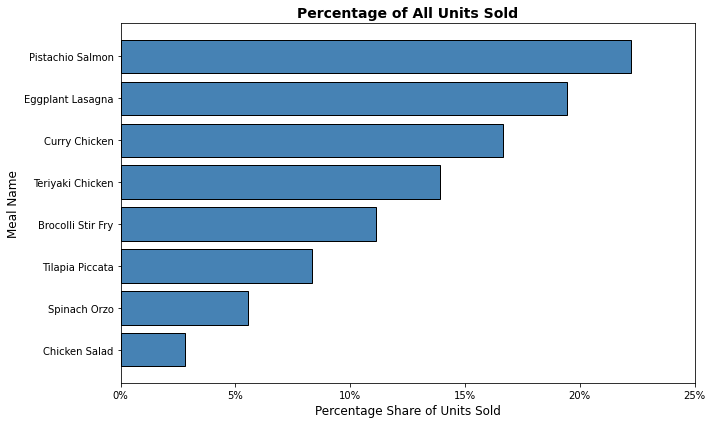

In [21]:
plt.figure(figsize=(10, 6))
plt.barh(df['meal_name'], df['pct_of_units'], color='steelblue', edgecolor='black')
plt.xlabel('Percentage Share of Units Sold', fontsize=12)
plt.ylabel('Meal Name', fontsize=12)
plt.title('Percentage of All Units Sold', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  
plt.xticks(ticks=plt.xticks()[0], 
    labels=[f'{int(tick)}%' for tick in plt.xticks()[0]])
plt.tight_layout()
plt.show()

Pistachio Salmon dominates product sales with 22.23% of units sold, followed by Eggplant Lasagna at 19.43% of units, with the top two products alone accounting for over 40% of all units sold.

## **4. Holiday Analysis**

### **4.1 Actual Sales for 2020 Including Closure Days**

What does the daily sales time series look like when we account for days with no transactions? This query constructs a complete date spine for 2020 and left-joins sales onto it. That ensures days with no sales show up explicitly as \($0\), which is essential for accurate time-series analysis and for detecting true closure days vs missing data.

In [22]:
query = """

with date_range as (
    select generate_series(
        '2020-01-01'::date,
        '2020-12-31'::date,
        '1 day'::interval
    )::date as date
)
select  dr.date,
        to_char(dr.date, 'Day') as day_of_week,
        coalesce(sum(sa.total_amount), 0) as total_sales
from date_range as dr
    left join sales as sa on sa.sale_date = dr.date
group by dr.date
order by dr.date

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,date,day_of_week,total_sales
0,2020-01-01,Wednesday,133776
1,2020-01-02,Thursday,261120
2,2020-01-03,Friday,263076
3,2020-01-04,Saturday,400368
4,2020-01-05,Sunday,394992
...,...,...,...
361,2020-12-27,Sunday,396096
362,2020-12-28,Monday,264852
363,2020-12-29,Tuesday,130440
364,2020-12-30,Wednesday,263424


From here we can compute baselines such as rolling averages or weekday-adjusted expectations and then quantify how specific holidays deviate from “normal” demand.

### **4.2 Holidays with Significant Sales Decrease**

Do holidays create meaningful demand dips relative to a baseline? This query compares actual holiday sales to a baseline expectation calculated by averaging total daily sales for the same day of week across the entire year. By controlling for day-of-week effects, we can identify whether holidays genuinely drive higher or lower sales than a typical day of that weekday.

In [23]:
query = """

with daily_sales as (
    select  sale_date,
            extract(dow from sale_date) as dow,
            sum(total_amount) as daily_total
    from sales
    group by sale_date, extract(dow from sale_date)
),
baseline as (
    select  dow,
            avg(daily_total) as avg_daily_sales
    from daily_sales
    group by dow
),
holiday_sales as (
    select  h.description as holiday_name,
            h.holiday_date,
            sum(sa.total_amount) as actual_sales,
            b.avg_daily_sales as expected_sales
    from holidays as h
        left join sales as sa on sa.sale_date = h.holiday_date
        join baseline as b on extract(dow from h.holiday_date) = b.dow
    group by h.description, h.holiday_date, b.avg_daily_sales
)
select  holiday_name,
        holiday_date,
        round(actual_sales::numeric, 2) as actual_sales,
        round(expected_sales::numeric, 2) as expected_sales,
        round(100.0 * (actual_sales - expected_sales) / expected_sales, 2) as pct_vs_expected
from holiday_sales
order by pct_vs_expected

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,holiday_name,holiday_date,actual_sales,expected_sales,pct_vs_expected
0,Independence Day,2020-07-04,134952,373489.62,-63.87
1,Mother's Day,2020-05-10,134496,357482.08,-62.38
2,Father's Day,2020-06-21,135120,357482.08,-62.20
3,Easter,2020-04-12,136164,357482.08,-61.91
4,New Year's Day,2020-01-01,133776,263255.77,-49.18
5,Labor Day,2020-09-07,130020,253225.38,-48.65
6,MLK Day,2020-01-20,130740,253225.38,-48.37
7,Memorial Day,2020-05-25,132624,253225.38,-47.63
8,President's Day,2020-02-17,135228,253225.38,-46.60
9,Veterans Days,2020-11-11,271920,263255.77,3.29


Most holidays significantly underperform expectations, with sales dropping 46-64% below the average for that day of week. There is reduced customer demand on major holidays like Independence Day, Mother's Day, and Easter. Veterans Day is the only holiday showing positive performance at +3.29% above expected sales, indicating it is normal operating day with slightly elevated demand. 

Since Acme Gourmet Meals is a meal delivery service, the reduced holiday demand likely reflects customers being off work, traveling, or preparing their own meals for holiday gatherings rather than ordering prepared meals for delivery.

## **5. Takeaways**

- The data reveals several patterns worth highlighting. Revenue differences across stores are primarily driven by transaction volume rather than pricing, since average ticket size remains remarkably consistent at around ~$64 across all five locations. Berkeley leads with $25.0M in sales (25.4% of total) compared to Nashville's $14.6M (14.8%), but this 71% revenue gap stems from Berkeley processing roughly 390K transactions versus Nashville's 228K, not from charging different prices.

- Weekend demand is substantial. Saturday and Sunday together account for roughly 38.5% of weekly revenue ($19.4M and $18.6M respectively), while Tuesday consistently represents the low point at just $6.9M, about 36% of Saturday's volume. This pattern suggests weekday effects are a critical for any forecasting. Monthly seasonality exists but is moderate, with revenue ranging from $7.6M to $9.0M and peaks in August and October.

- Product concentration is striking. Pistachio Salmon dominates as the top-selling item across every store location and every month, accounting for 1.83M units sold (22.23% of total volume). The top two products alone represent over 40% of all units sold, which creates both operational simplicity and concentration risk.

- The holiday analysis reveals that most holidays significantly underperform day-of-week baselines. After controlling for weekday effects, holidays like Independence Day, Mother's Day, and Easter show sales drops of 46-64% compared to typical days of that same weekday. This makes intuitive sense for a meal delivery service where customers are likely traveling, off work, or preparing their own holiday meals. Veterans Day is an interesting exception, showing a 3.29% lift above expected sales, suggesting it operates as a normal business day with slightly elevated demand.

- One clear opportunity emerges from the customer acquisition data: 35 customers signed up but never made a purchase. While this represents a small fraction of the customer base, it points to potential friction in activation that could be further investigated. 